In [245]:
import os
import sys
import numpy as np

import umap.umap_ as umap

%load_ext autoreload
%autoreload 2

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_full"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
output_directory = os.path.join(image_directory, "outputs")

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
#image_directory = ALLDIR

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

elements, data, dims, sd_data, sd_dims = processops.compile(image_directory)

#data, dims = processops.data_crop(data, dims, 100, 500, 150, 350)
data, dims = processops.data_crop(data, dims, 1500, 2000, 890, 1090)
sd_data, sd_dims = processops.data_crop(sd_data, sd_dims, 1500, 2000, 890, 1090)

#data, elements, dims, sd_data, sd_dims = processops.compile(image_directory)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_full
-----
Map files found: 33
Elements identified: ['Ag', 'AgL', 'Al', 'As', 'BaL', 'BiL', 'BiM', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Mo', 'MoL', 'Na', 'Ni', 'P', 'Rb', 'S', 'Se', 'Si', 'Sr', 'TeL', 'Ti', 'V', 'WL', 'Y', 'Zn', 'sum']
-----------------
READING MAP DATA
Initial shape: (1166, 2048, 33)
Revised shape: (1092, 2048, 33)
-----
-----------------
READING VARIANCE DATA
Initial shape: (583, 1024, 33)
Revised shape: (546, 1024, 33)
-----
(559104, 33)


ValueError: mismatch between dimensions of data and rescaled variance, (1092, 2048) vs (2048, 33) 

(100000,)
ELEMENT MAP: Si
(24), Si, max: 666.47, 98: 391.50, avg: 74.78


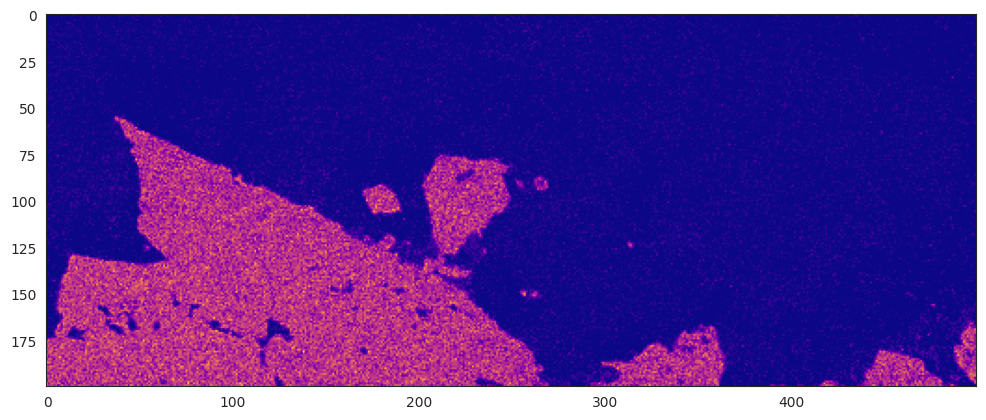

(100000,)
ELEMENT MAP: Si
(24), Si, max: 1299.65, 98: 1158.63, avg: 472.03


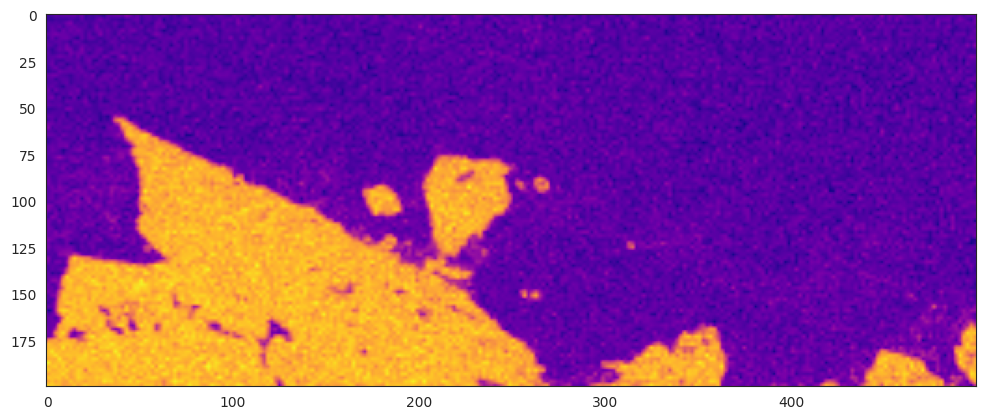

In [157]:
import xfmreadout.utils as utils
import matplotlib.pyplot as plt

ELEMENT = "Si"

vis.show_map(data, dims, elements, ELEMENT)

vis.show_map(sd_data, sd_dims, elements, ELEMENT)



Si -- dataq99: 536.154, sdq2: 261.656, max: 666.468
RATIO: 1.4640729534354475
(100000,)


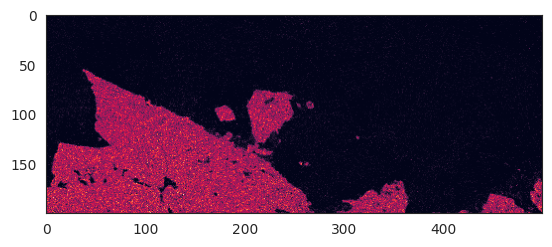

In [238]:
from math import sqrt, fmod

import xfmreadout.imgops as imgops


#----
ELEMENT = "Si"
SD_MULTIPLE = 3
i = utils.findelement(elements, ELEMENT)

def calcqs(data, sd):
    dqval=0.999
    avg_data = np.average(data)
    max_data = np.max(data)
    q99_data = utils.mean_within_quantile(data, qmin=dqval)

    sdqmin=0.25
    sdqmax=0.5
    avg_sd = np.average(sd)
    q2_sd = utils.mean_within_quantile(sd, qmin=sdqmin, qmax=sdqmax)

    ratio = q99_data / (q2_sd*SD_MULTIPLE)

    print(f"{ELEMENT} -- dataq99: {q99_data:.3f}, sdq2: {q2_sd:.3f}, max: {max_data:.3f}")

    ratio = (q2_sd*SD_MULTIPLE) / q99_data

    print(f"RATIO: {ratio}")

    return ratio, q2_sd, q99_data

ratio, q2_sd, q99_data = calcqs(data[:,i], sd_data[:,i])

newdata = np.copy(data[:,i])
newsd = np.copy(sd_data[:,i])

map_pre = utils.map_roll(newdata, dims)

plt.imshow(map_pre)

#----



In [240]:
data.shape

(100000, 33)

Applying gaussian blur
(100000,)
Si -- dataq99: 88.868, sdq2: 29.254, max: 99.327
RATIO: 0.9875577165787709
Finished after 1 cycles
(100000, 1)


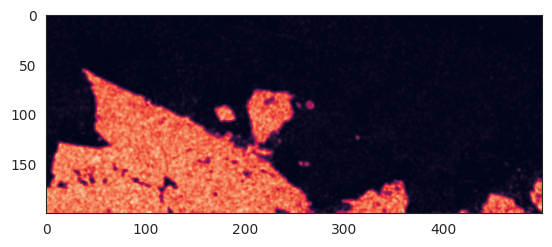

In [225]:
j=0
while ratio >= 1:
    print("Applying gaussian blur")
    newdata, newsd = imgops.apply_gaussianblur(newdata, newsd, dims, 1)
    newdata = newdata/4
    newsd = newsd/4

    ratio, q2_sd, q99_data = calcqs(newdata, newsd)
    j+=1

print(f"Finished after {j} cycles")
map_post = utils.map_roll(newdata, dims)

plt.imshow(map_post)

In [188]:
maps = utils.map_roll(data, dims)

maps.shape[:2]

(100000, 33)


(200, 500)

LOADING EMBED
CALCULATING CATS
RUNNING CLASSIFIER
cluster 0, count: 7555
cluster 1, count: 14248
cluster 2, count: 10292
cluster 3, count: 5164
cluster 4, count: 17078
cluster 5, count: 7948
cluster 6, count: 5458
cluster 7, count: 5920
cluster 8, count: 4621
cluster 9, count: 5464
cluster 10, count: 11059
cluster 11, count: 5193
---------------------------
CLASSIFICATION COMPLETE
---------------------------
total time: 5.12 s
time per pixel: 5.1e-05 s
---------------------------
(100000, 3)
running reducer: PCA across data with shape: (100000, 3)
[[ 1.0439031   5.7517176   4.7335095 ]
 [10.427779    4.635341    2.7627175 ]
 [10.256543    4.2928786   6.896155  ]
 [-1.3821393   7.994077    5.993885  ]
 [ 0.33325535  0.21002364  1.4181579 ]
 [-1.0694253  -1.4227582   4.5507283 ]
 [-1.8818744   1.3127322   3.8294332 ]
 [ 0.9246889  -0.5959633   7.8292103 ]
 [ 1.3834386   3.35142     4.660116  ]
 [ 3.1688023  -0.83223677  7.562882  ]
 [ 0.17235942 11.032503    4.296907  ]
 [ 1.6694602   9.

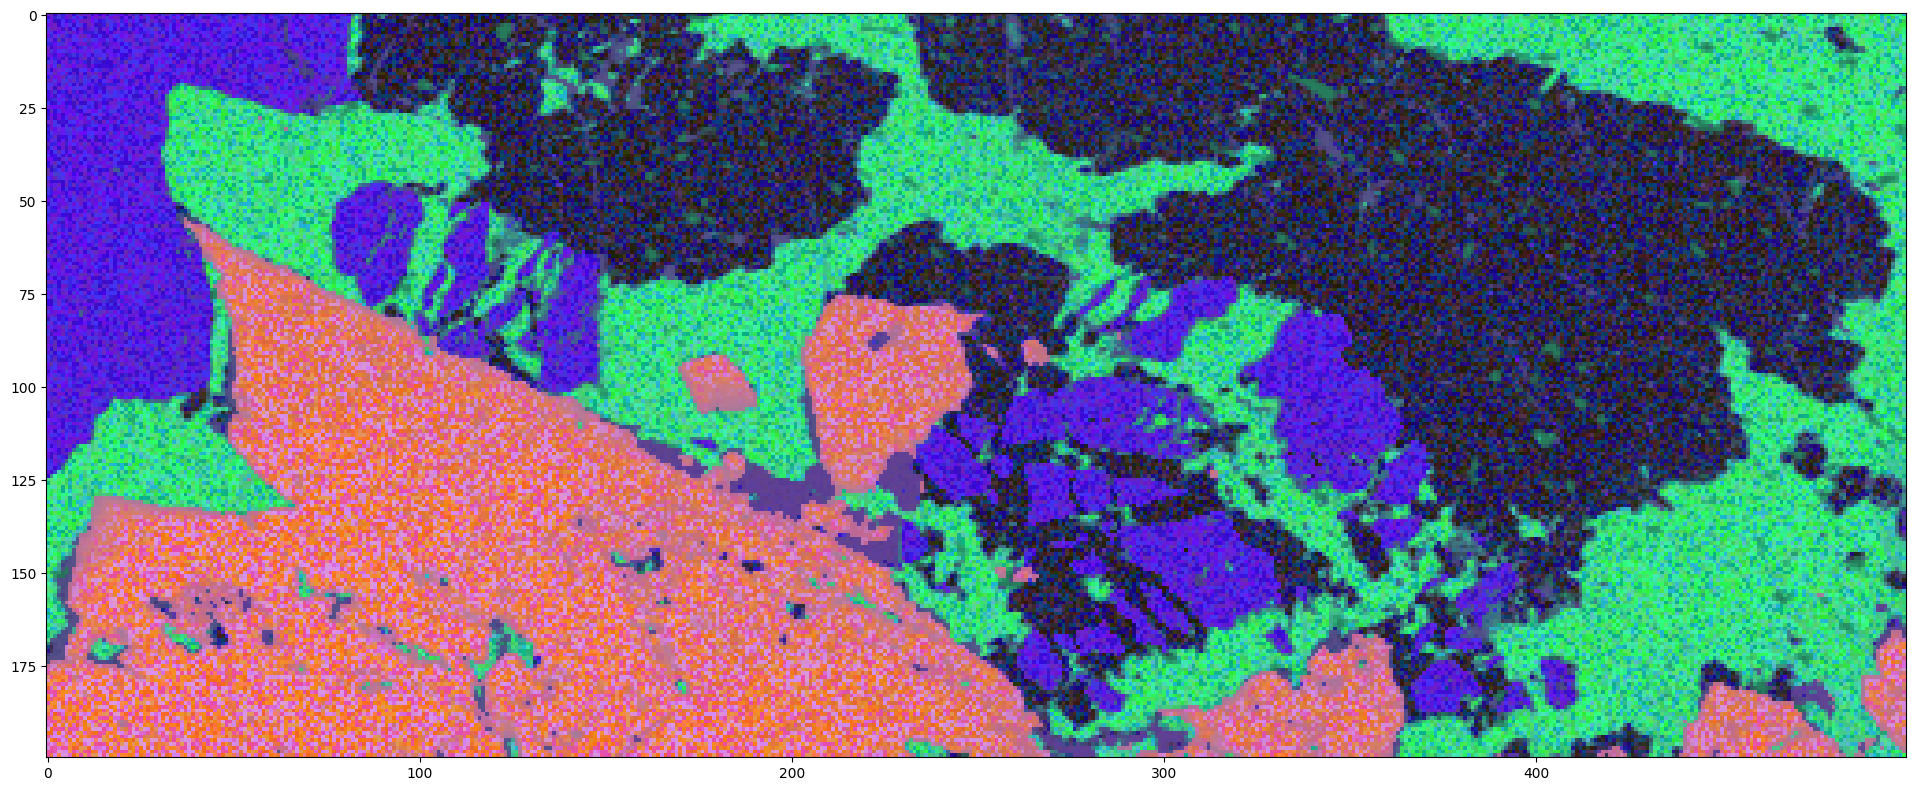

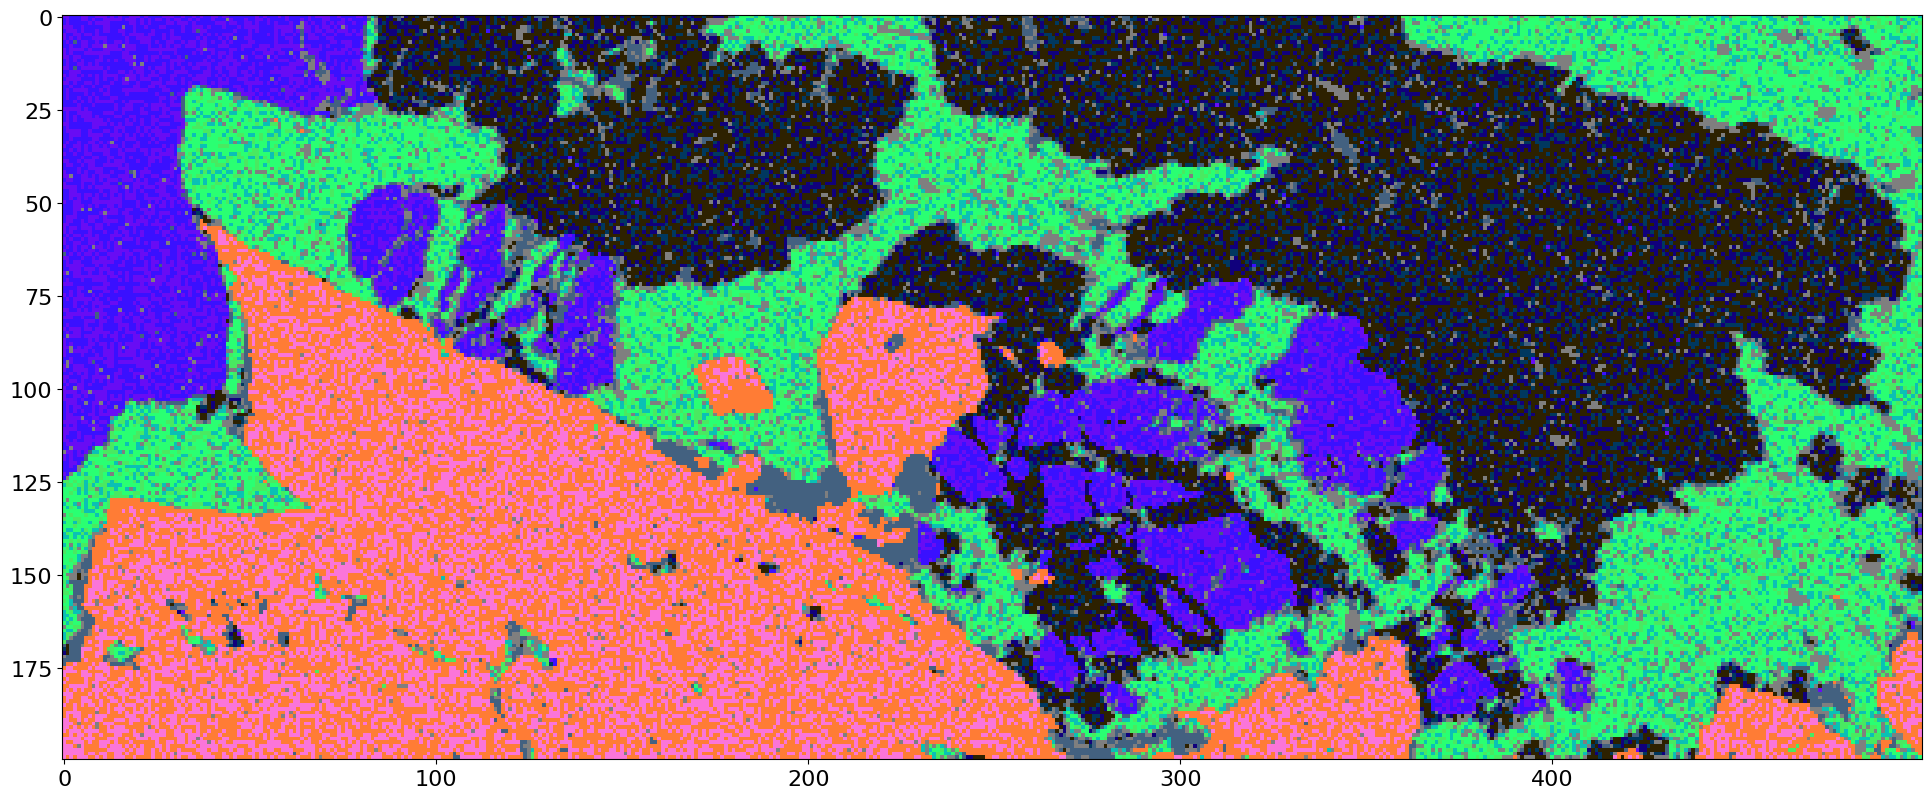

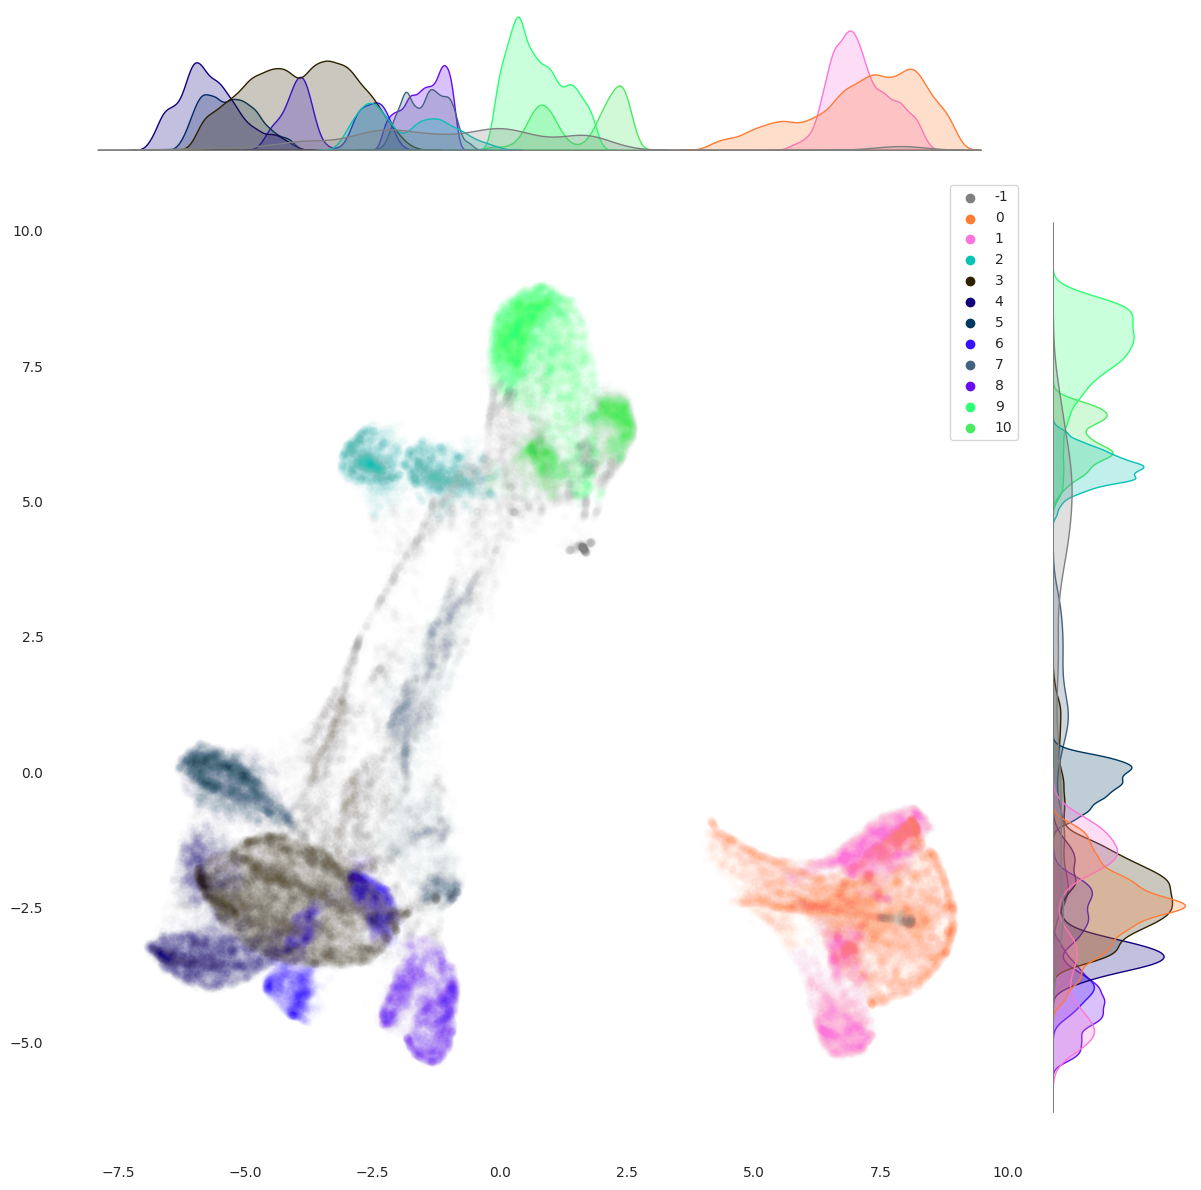

Ag, max: 9.54, 98: 0.55, avg: 0.06
AgL, max: 44.68, 98: 2.18, avg: 0.22
Al, max: 128.62, 98: 38.73, avg: 4.65
As, max: 0.11, 98: 0.00, avg: 0.00
BaL, max: 3.11, 98: 0.40, avg: 0.10
BiL, max: 16.61, 98: 0.03, avg: 0.01
BiM, max: 41.63, 98: 3.09, avg: 0.82
Ca, max: 273.40, 98: 43.70, avg: 3.82
Cl, max: 16.51, 98: 0.62, avg: 0.04
Compton, max: 0.81, 98: 0.68, avg: 0.16
Cr, max: 0.67, 98: 0.16, avg: 0.05
Cu, max: 161.32, 98: 110.12, avg: 26.64
Fe, max: 201.66, 98: 151.39, avg: 86.58
K, max: 11.10, 98: 0.89, avg: 0.11
Mg, max: 849.79, 98: 173.93, avg: 17.29
Mn, max: 122.59, 98: 2.95, avg: 0.57
Mo, max: 0.68, 98: 0.20, avg: 0.11
MoL, max: 35.38, 98: 6.39, avg: 0.38
Na, max: 1106.66, 98: 195.88, avg: 20.31
Ni, max: 2.14, 98: 0.48, avg: 0.09
P, max: 15.68, 98: 3.32, avg: 0.54
Rb, max: 0.04, 98: 0.02, avg: 0.01
S, max: 413.73, 98: 192.99, avg: 82.59
Se, max: 0.03, 98: 0.00, avg: 0.00
Si, max: 398.68, 98: 234.19, avg: 44.73
Sr, max: 0.03, 98: 0.02, avg: 0.00
TeL, max: 3.55, 98: 0.22, avg: 0.03
T

In [4]:
%%time


FORCE_EMBED=False
FORCE_CLUST=True
OVERWRITE=True

categories, classavg, embedding = clustering.run(data, image_directory, sqrt=True, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)

palette = vis.plot_clusters(categories, classavg, embedding, dims, output_directory=output_directory)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





In [5]:
import pandas as pd
from tabulate import tabulate

elements

df = pd.DataFrame(data=classavg, columns=elements)

df
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+------------+-----------+-----------+-------------+-------------+-------------+----------+-----------+------------+-----------+-------------+------------+-----------+-----------+------------+----------+-----------+-----------+------------+------------+-----------+-------------+----------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+-------------+
|    |         Ag |       AgL |        Al |          As |         BaL |         BiL |      BiM |        Ca |         Cl |   Compton |          Cr |         Cu |        Fe |         K |         Mg |       Mn |        Mo |       MoL |         Na |         Ni |         P |          Rb |        S |          Se |          Si |          Sr |        TeL |         Ti |          V |          WL |           Y |         Zn |         sum |
|----+------------+-----------+-----------+-------------+-------------+-------------+----------+-----------+------------+-----------+---

In [8]:
import pandas as pd
from tabulate import tabulate
import xfmreadout.utils as utils

raw_data = data

def calc_classavg(dataset, categories, n_clusters, n_channels):
    """
    calculate summed spectrum for each cluster
    args: 
        dataset, spectrum by px
        catlist, categories by px
    returns:
        specsum, spectrum by category
    
    aware: nclust, number of clusters
    """
    specsum=np.zeros((n_clusters,n_channels))

    if n_clusters != utils.count_categories(categories)[0]:
        raise ValueError("cluster count mismatch")

    for i in range(np.min(categories), np.max(categories)):
        datcat=dataset[categories==i]
        print(f"cluster {i}, count: {datcat.shape[0]}") #DEBUG
        pxincat = datcat.shape[0]   #no. pixels in category i
        specsum[i,:]=(np.sum(datcat,axis=0))/pxincat
    return specsum

n_channels = data.shape[1]
n_clusters, category_list = utils.count_categories(categories)

classavg2=calc_classavg(raw_data, categories, n_clusters, n_channels) 
df = pd.DataFrame(data=classavg, columns=elements)
print(tabulate(df, headers='keys', tablefmt='psql'))




print(n_clusters)
print(category_list)
for i in category_list:
    print(i)
print(len(category_list))



cluster -1, count: 22546
cluster 0, count: 5205
cluster 1, count: 4520
cluster 2, count: 7652
cluster 3, count: 4519
cluster 4, count: 3776
cluster 5, count: 4486
cluster 6, count: 4411
cluster 7, count: 7923
cluster 8, count: 5270
+----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-----------+
|    |          Al |          As |          Ca |          Cl |     Compton |          Cr |          Cu |          Fe |           K |          Mn |         Mo |         MoL |          Ni |           P |         S |          Si |          Ti |           V |          Zn |       sum |
|----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+---

In [16]:
n_clusters = len(category_list)

for i in range(n_clusters):
    print(i)

0
1
2
3
4
5
6
7
8
9
10


(80000,)
(80000,)
(80000,)
(80000,)


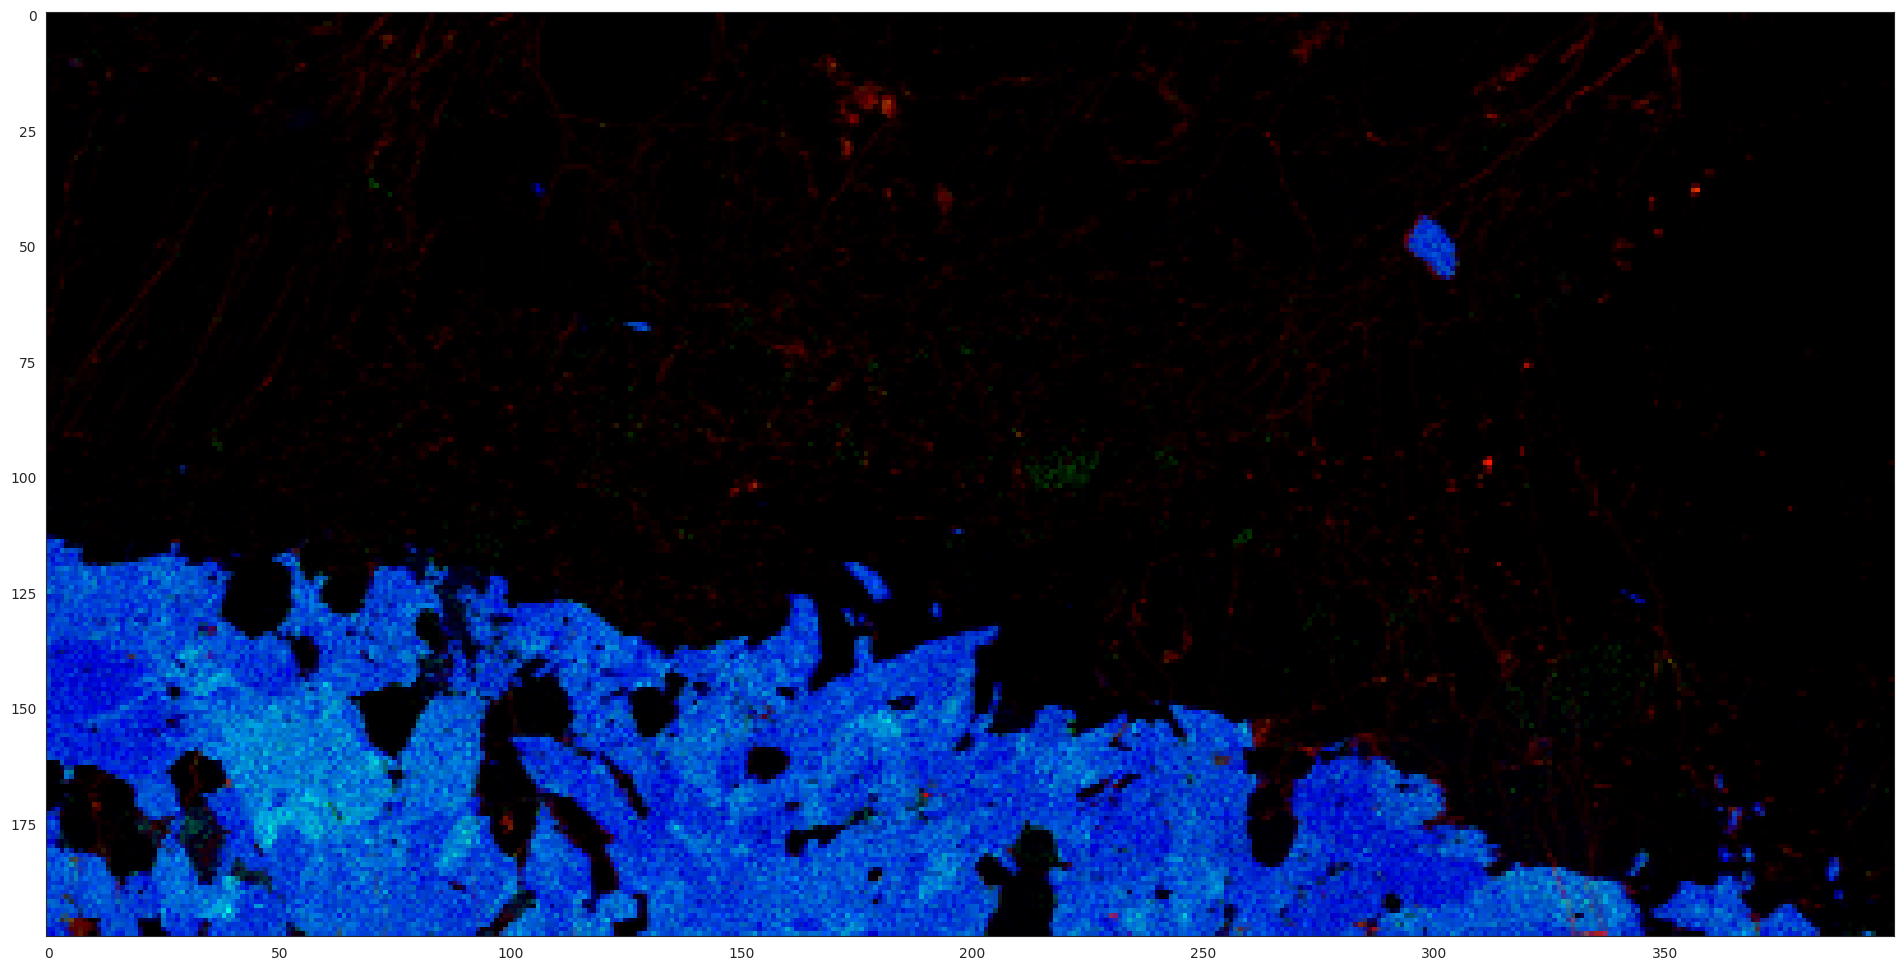

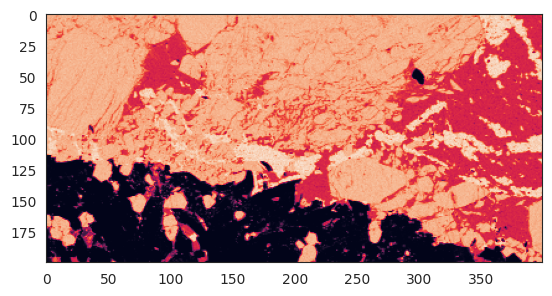

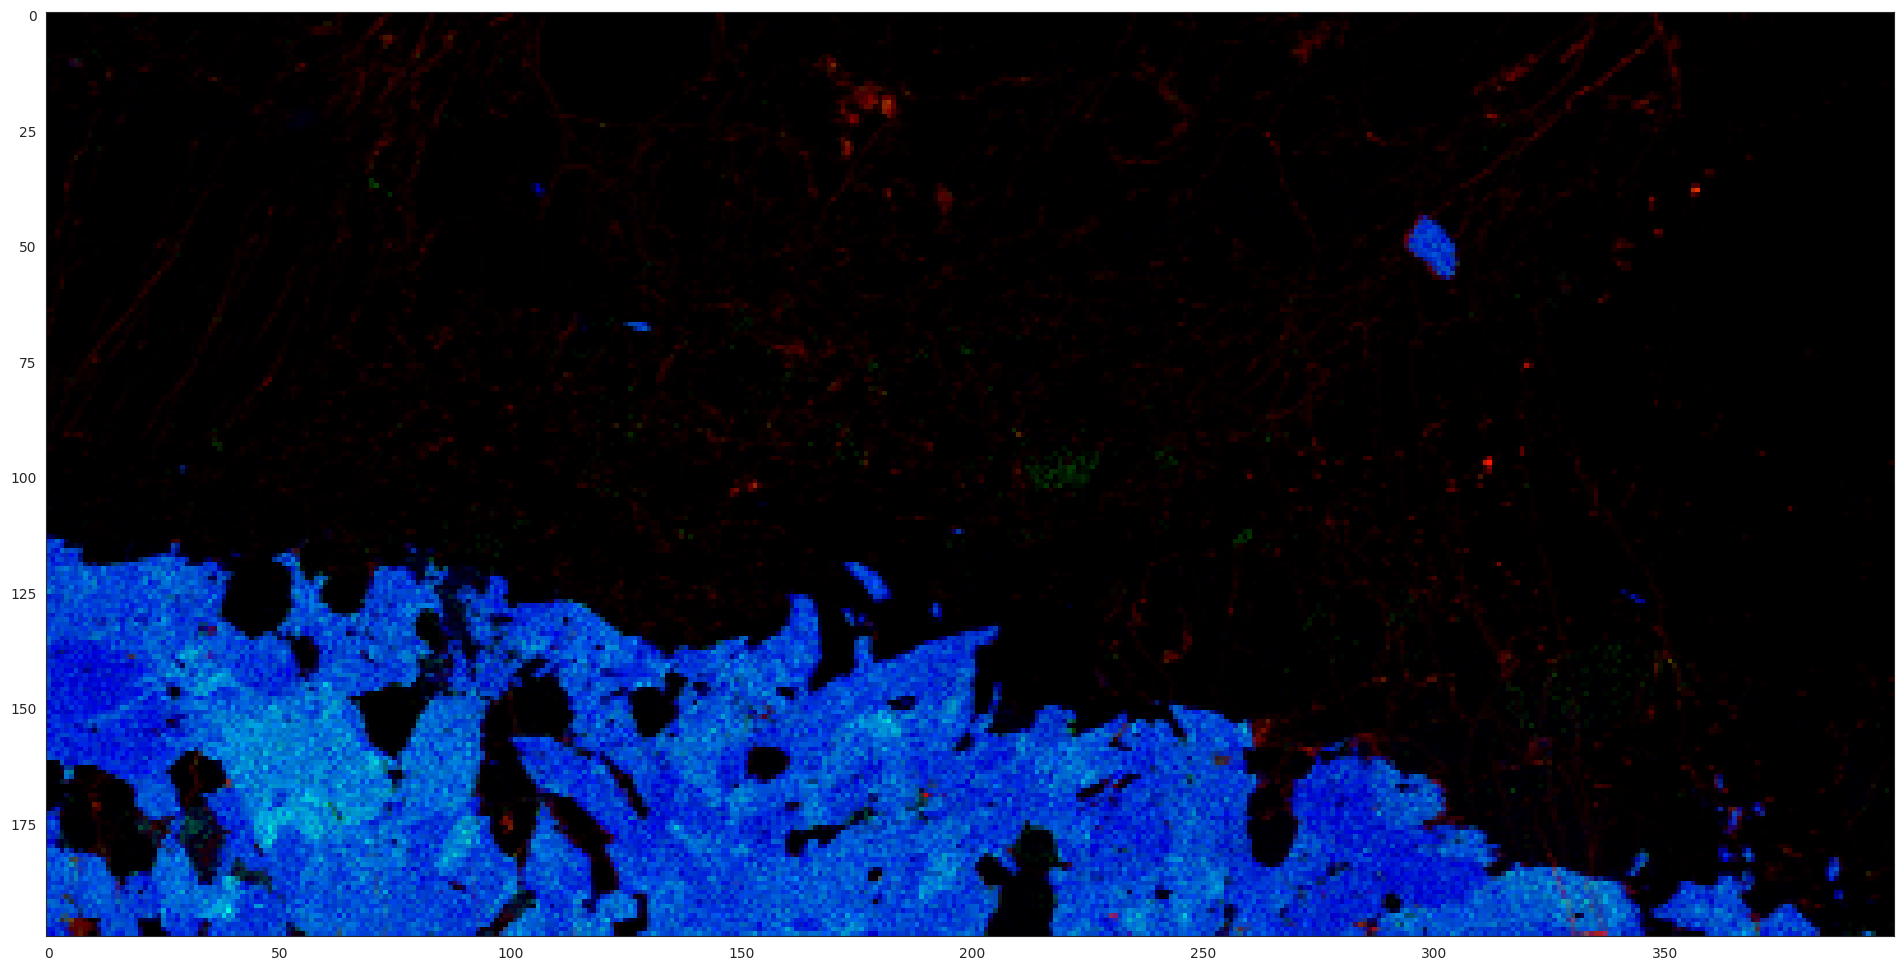

In [36]:
import xfmreadout.utils as utils
import xfmreadout.visualisations as vis

r = utils.get_map(data, dims, elements, 'Fe')
plt.imshow(r)

#vis.tricolour_enames('Fe','Cu','Si', data, dims, elements)
vis.tricolour_enames('Ca','As','Si', data, dims, elements)

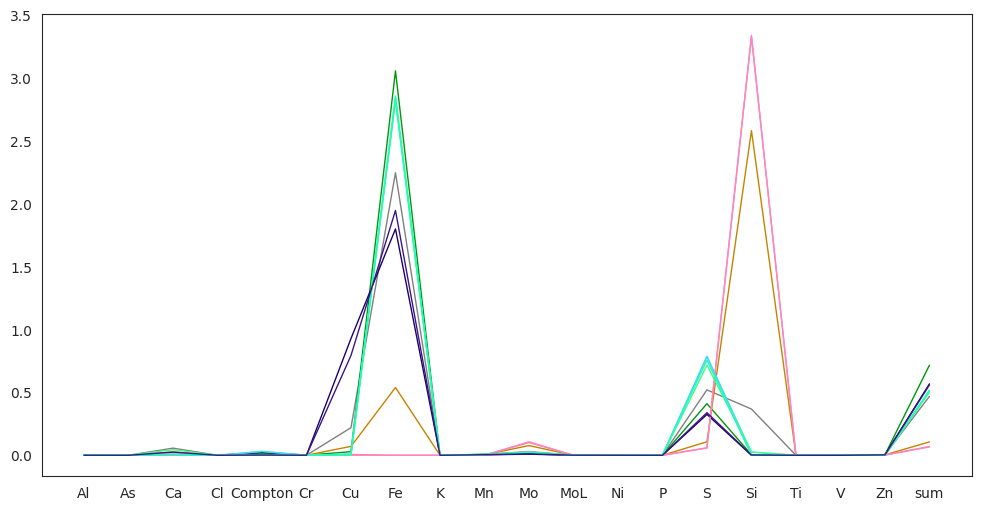

In [40]:
from matplotlib import colors

vis.category_avgs(categories, elements, classavg, palette=palette)